# Validation Set 2 LTOO

In [5]:
import os
import time

import itertools
from collections import defaultdict


from openpyxl import load_workbook
import networkx as nx

##### PyBEL imports

In [6]:
import pybel
import pybel_tools as pbt

from pybel import BELGraph
from pybel.constants import RELATION, ANNOTATIONS
from pybel.dsl import Abundance, BiologicalProcess, CentralDogma, ListAbundance, Reaction
from pybel.struct import get_subgraph_by_annotation_value
from pybel.struct.summary import count_functions

pybel.get_version()

'0.13.2'

##### PathMe import 

In [7]:
from pathme.constants import REACTOME_BEL, KEGG_BEL, WIKIPATHWAYS_BEL, PATHME_DIR
from pathme.export_utils import to_gml

##### DiffuPath import 

In [23]:
import diffupath

from diffupath.constants import DATA_DIR
from diffupath.validation_datasets_parsers import parse_set2

from diffupath.pathme_importer import get_labels_by_db_and_omic_from_pathme, get_labels_by_db_and_omic_from_graph
from diffupath.input_mapping import get_mapping, get_mapping_subsets, get_mapping_two_dim_subsets
from diffupath.utils import print_dict_dimensions, get_labels_set_from_dict, reduce_dict_dimension, get_count_and_labels_from_two_dim_dict, from_pickle, to_pickle, get_three_venn_intersections, random_disjoint_intersection_three_subsets
from diffupath.views import show_heatmap, show_venn_diagram


## 1. Load Data Set 1: Input Scores

In [9]:
dataset2_labels_by_omics = parse_set2(os.path.join(DATA_DIR, 'validation_datasets', 'set2.xlsx'))
dataset2_all_labels = get_labels_set_from_dict(dataset2_labels_by_omics)
print_dict_dimensions(dataset2_labels_by_omics, 'Dataset2 imported labels:')

Dataset1 imported labels:
Total number of genes: 4941  
Total number of micrornas: 100  
Total number of metabolite: 21  
Total: 5062 


In [10]:
mirnas_dataset =  dataset2_labels_by_omics['micrornas']

## 2. Load Backrgound Network and Kernel matrix

### 2.1. Import PathMeUniverse network graph

In [11]:
pathme_universe_graph_no_flatten = pybel.from_pickle(os.path.join(DATA_DIR, 'pickles', 'universe', 'pathme_universe_bel_graph_no_flatten.bel.pickle'))
pathme_universe_graph_no_flatten.summarize()
count_functions(pathme_universe_graph_no_flatten)


PathMe Universe v1.0.0
Number of Nodes: 48643
Number of Edges: 104713
Number of Citations: 7696
Number of Authors: 0
Network Density: 4.43E-05
Number of Components: 6860
Number of Warnings: 0


Counter({'Composite': 1605,
         'Abundance': 7046,
         'BiologicalProcess': 2857,
         'Complex': 9048,
         'Reaction': 13576,
         'Gene': 14511})

In [12]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(pathme_universe_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

<Figure size 1000x400 with 2 Axes>

##### Check and filter isolates / Unconnected nodes

In [13]:
nx.number_of_isolates(pathme_universe_graph_no_flatten)

6426

In [14]:
pathme_universe_graph_no_flatten.remove_nodes_from({
    node
    for node in nx.isolates(pathme_universe_graph_no_flatten)
})

### 2.2. Get KEGG subgraph from PathMeUniverse graph

In [15]:
kegg_pathme_graph_no_flatten = get_subgraph_by_annotation_value(pathme_universe_graph_no_flatten, 'database', 'kegg')
kegg_pathme_graph_no_flatten.summarize()
count_functions(kegg_pathme_graph_no_flatten)

None vNone
Number of Nodes: 13162
Number of Edges: 35122
Number of Citations: 2
Number of Authors: 0
Network Density: 2.03E-04
Number of Components: 65
Number of Warnings: 0


Counter({'Composite': 1596,
         'Complex': 406,
         'Gene': 6149,
         'Abundance': 1762,
         'Reaction': 3137,
         'BiologicalProcess': 112})

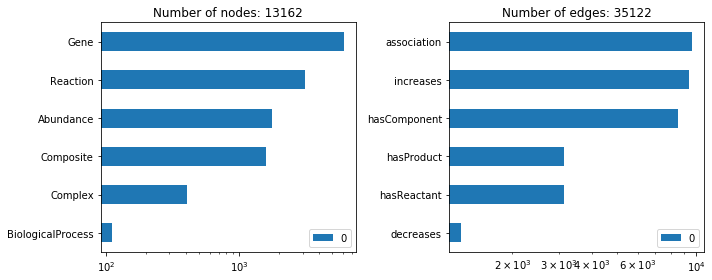

In [16]:
import matplotlib.pyplot as plt
from pybel_tools.summary import plot_summary, count_top_centrality
plot_summary(kegg_pathme_graph_no_flatten, plt, figsize=(10, 4))
plt.show()

### 2.3. Get entity labels subsets by entity type (omic) and by database

#####  2.3.2.  From PathMeUniverse KEGG subgraph

In [17]:
bg_labels_from_pathmeuniverse_by_db_and_omic, bg_labels_from_pathmeuniverse_by_omic_and_db =  get_labels_by_db_and_omic_from_graph(kegg_pathme_graph_no_flatten)

print_dict_dimensions(bg_labels_from_pathmeuniverse_by_db_and_omic, 'Entities in PathMeUniverse :')

Entities in PathMeUniverse :
Total number of kegg: gene_nodes(6027), mirna_nodes(122), metabolite_nodes(1762), bp_nodes(112),  
Total: 8023 


In [18]:
bg_labels_from_pathmeuniverse_by_omic = reduce_dict_dimension(bg_labels_from_pathmeuniverse_by_omic_and_db)

### 2.4. Get Background  Matrix Kernel

In [19]:
kernel_path = os.path.join(DATA_DIR, 'pickles', 'by_db_validation', 'regularised_laplacian_kernel_kegg.pickle')

##### Generate kernel OR load from pickle

DiffuPy to generate laplacian_kernel

In [20]:
#import diffupy
#from diffupy.kernels import regularised_laplacian_kernel

In [21]:
#background_mat = regularised_laplacian_kernel(kegg_pathme_graph_no_flatten)
#to_pickle(regularised_laplacian_kernel, kernel_path)

Import kernel from pickle

In [24]:
background_mat = from_pickle(kernel_path)

## 3. Dataset label mapping to PathMeEntities

##### All kernel matrix (background network) row labels for the mapping

In [25]:
background_labels = background_mat.rows_labels

### 3.1. General mapping

In [26]:
all_labels_mapping = get_mapping(dataset2_all_labels, background_labels, title = 'Global mapping: ', mirnas = mirnas_dataset, print_percentage = True)


Global mapping:  (1627) 32.141446068747534%


### 3.2. Mapping by subsets

#### 3.2.1. Mapping by entity type/omic

In [27]:
mapping_by_entity, _, _ = get_mapping_subsets(dataset2_labels_by_omics, background_labels, 'entity type/omic', mirnas = mirnas_dataset)


Mapping by entity type/omic:
genes (1619) 32.76664642784861%
micrornas (14) 14.000000000000002%
metabolite (8) 38.095238095238095%
Total (1641) 32.41801659423153% 



In [28]:
micrornas_mapping = mapping_by_entity['micrornas'][0]

#### 3.2.2. Mapping by database

In [29]:
background_entites_by_db = {db : set(itertools.chain.from_iterable(entities.values())) for db, entities in bg_labels_from_pathmeuniverse_by_db_and_omic.items()}
mapping_by_db, _, _ = get_mapping_subsets(background_entites_by_db, dataset2_all_labels, 'database', mirnas = mirnas_dataset, submapping = background_labels, mirnas_mapping = micrornas_mapping, percentage_reference_labels = True)


Mapping by database:
kegg (1641) 32.41801659423153%
Total (1641) 32.41801659423153% 



#### 3.2.3. Mapping by entity type and database (two dimentions)

In [30]:
mapping_by_database_and_entity, total_percentage, total_dimention = get_mapping_two_dim_subsets(bg_labels_from_pathmeuniverse_by_db_and_omic, dataset2_all_labels, relative_statistics = dataset2_labels_by_omics, mirnas_mapping = micrornas_mapping)


Mapping by Kegg:
gene_nodes (1615) 32.68569115563651%
mirna_nodes (14) 14.000000000000002%
metabolite_nodes (12) 57.14285714285714%
bp_nodes (0) 0%
Total (1641) 20.4536956250779% 

Total (1641) 32.41801659423153% 



### 3.3. Mapping descriptive view

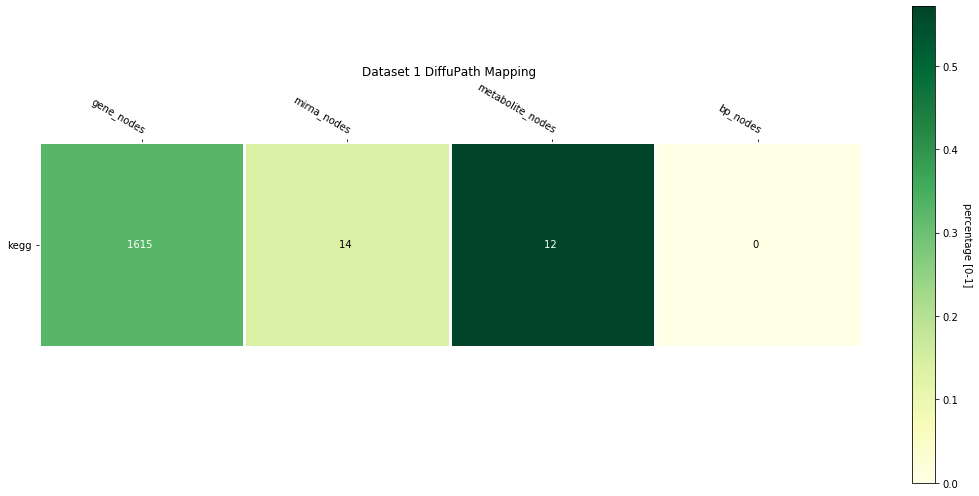

In [31]:
count, percentage, db_labels, entity_labels  = get_count_and_labels_from_two_dim_dict(mapping_by_database_and_entity)

show_heatmap(count, percentage, db_labels, entity_labels)


## 4. Cross-validation

In [32]:
from diffupath.views import box_plot_from_dict, box_plot_from_two_dimension_dict
from diffupath.cross_validation import cross_validation_one_x_in

### 4.1. Random Scheme

#### 4.1.1.  By method

In [33]:
mapping_by_entity_sets = {entity:set_ent[0] for entity, set_ent in mapping_by_entity.items()}

In [37]:
#del mapping_by_entity['bps']

In [38]:
auroc_metrics_by_method = {}
auprc_metrics_by_method = {}

In [39]:
mapping_by_entity_sets

{'genes': {'znf189',
  'lipc',
  'nudt2',
  'mylk',
  'hmgcl',
  'ldlr',
  'agxt',
  'arhgef26',
  'socs2',
  'got1',
  'vav3',
  'fut8',
  'socs7',
  'oas3',
  'ash2l',
  'amotl2',
  'gart',
  'atp1a1',
  'klc1',
  'nr1d1',
  'alg8',
  'sat1',
  'phlpp1',
  'reck',
  'cstf2',
  'atf2',
  'ywhab',
  'nmnat1',
  'sort1',
  'ccdc6',
  'apoc3',
  'cyp19a1',
  'smg7',
  'spp1',
  'rassf1',
  'akr1d1',
  'sema4g',
  'znf195',
  'enpp1',
  'st3gal6',
  'flcn',
  'micb',
  'mlx',
  'ctu2',
  'znf25',
  'atg5',
  'gpx7',
  'fkrp',
  'cpt2',
  'il22ra1',
  'eif2ak2',
  'pgm2',
  'ddit3',
  'arg2',
  'amt',
  'znf816',
  'mtmr2',
  'proc',
  'slc9a1',
  'znf101',
  'tomm40l',
  'fgfr3',
  'cdc14b',
  'alcam',
  'strap',
  'rras2',
  'eprs',
  'tnfsf9',
  'sik1',
  'ephb4',
  'il1r2',
  'aldh7a1',
  'mad2l1',
  'auh',
  'pcf11',
  'lif',
  'b4galt6',
  'pcbp2',
  'znf223',
  'dlg1',
  'apob',
  'foxa3',
  'ganab',
  'rasd1',
  'il1r1',
  'lmna',
  'cyb5r4',
  'hsd3b7',
  'vasp',
  'ftcd',
  'acaa

In [40]:
auroc_metrics_by_method['raw'], auprc_metrics_by_method['raw'], scores_raw = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, missing_value = 0)


100%|██████████| 1/1 [00:17<00:00, 17.98s/it]


In [41]:
auroc_metrics_by_method['ml'], auprc_metrics_by_method['ml'], scores_ml = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, rows_unlabeled = True)


100%|██████████| 1/1 [00:17<00:00, 17.80s/it]


In [42]:
auroc_metrics_by_method['z /ml'], auprc_metrics_by_method['z /ml'], scores_z = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, rows_unlabeled = True, z = True)


100%|██████████| 1/1 [00:26<00:00, 26.65s/it]


In [43]:
auroc_metrics_by_method['z /raw'], auprc_metrics_by_method['z /raw'], scores_z = cross_validation_one_x_in(mapping_by_entity_sets, background_mat, k = 1, rows_unlabeled = False, z = True)


100%|██████████| 1/1 [00:27<00:00, 27.01s/it]


In [44]:
def subvert_two_dim_dict(d):
    d2 = defaultdict(dict)
    for k1, v1 in d.items():
        for k2, v2 in v1.items():
            d2[k2][k1] = v2

    return dict(d2)

In [45]:
s_auroc_metrics_by_method = subvert_two_dim_dict(auroc_metrics_by_method)
s_auprc_metrics_by_method = subvert_two_dim_dict(auprc_metrics_by_method)

In [104]:
box_plot_from_two_dimension_dict(s_auroc_metrics_by_method['genes'], 'Genes', 'AUROC')

In [105]:
box_plot_from_two_dimension_dictr(s_auroc_metrics_by_method['metabolite'], 'Metabolites', 'AUROC')

In [109]:
box_plot_from_two_dimension_dictr(s_auroc_metrics_by_method['micrornas'], 'Mirnas', 'AUROC')

In [118]:
box_plot_from_two_dimension_dictr(s_auprc_metrics_by_method['micrornas'], 'Mirnas', 'AUPRC')

In [120]:
box_plot_from_two_dimension_dictr(s_auprc_metrics_by_method['metabolite'], 'Metabolite', 'AUPRC')

In [121]:
box_plot_from_two_dimension_dictr(s_auprc_metrics_by_method['genes'], 'Genes', 'AUPRC')

In [ ]:
scores_genes_micrornas = scores_raw['genes']['micrornas'][0].order_rows(reverse=True, col_ref_idx = 0)
scores_micrornas_genes = scores_raw['micrornas']['genes'][0].order_rows(reverse=True, col_ref_idx = 1)
scores_micrornas_metabolite = scores_raw['micrornas']['metabolite'][0].order_rows(reverse=True, col_ref_idx = 1)

In [ ]:
print(scores_genes_micrornas)

In [ ]:
print(scores_micrornas_genes)

In [ ]:
box_plot_from_dict(auroc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

In [ ]:
box_plot_from_dict(auprc_metrics_by_method, 'Random Cross Validation', 'Method type', 'AUROC')

#### 5.1.2.  By entity

In [ ]:
auroc_metrics_by_entity, auprc_metrics_by_entity = cross_validation_by_subset_same_diff_input(mapping_by_entity, background_mat, k = 10)


In [ ]:
box_plot_from_dict(auroc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUROC')


In [ ]:
box_plot_from_dict(auprc_metrics_by_entity, 'Random Cross Validation', 'Entity type', 'AUPRC')

### 5.2. Leave Two Omics Out (LTOO)

In [ ]:
mapping_by_db

In [ ]:
auroc_metrics_by_db, auprc_metrics_by_db = cross_validation_one_x_in_disjoint(mapping_by_db,
                                                                              disjoint = True,
                                                                              background_mat, 
                                                                              k = 1)

In [ ]:
box_plot_from_dict(auroc_metrics_by_entity, 'Leave Two DB Out Validation', 'DB', 'AUROC')